# TRANSFORMERS BY ARIHARASUDHAN

In [3]:
!pip install torch numpy matplotlib spacy torchtext seaborn 

# ![HELLO](transimg0.jpg)

# IMPORT NECESSARY PACKAGES

This imports the NumPy library, which provides support for numerical operations and arrays in Python.

In [1]:
import numpy as np

These lines import the PyTorch library, including modules for defining and training neural networks (torch.nn), as well as various functions for applying activation functions and loss functions (torch.nn.functional).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

These lines import some additional Python standard libraries.

In [3]:
import math, copy, time

This line imports the `Variable` class from the `torch.autograd` module. However, in recent versions of PyTorch (1.0 and later), the use of `Variable` is deprecated as tensors are now directly used for automatic differentiation. The use of `Variable` from `torch.autograd` was a common practice in earlier versions of PyTorch (before version 1.0) for enabling automatic differentiation. It allowed you to track computations involving tensors and automatically compute gradients with respect to those tensors. In earlier versions, `Variable` was used to wrap tensors and record the operations performed on them. By doing so, PyTorch could build a computational graph to track the operations and compute gradients using backpropagation. However, starting from PyTorch 1.0, tensors themselves have built-in support for automatic differentiation, and the use of `Variable` is no longer necessary.

In [4]:
from torch.autograd import Variable

These lines import the Matplotlib library, which provides various functions for creating plots and visualizations in Python. The `seaborn` library is used to set the plot context, and `%matplotlib inline` is a Jupyter Notebook magic command that allows plots to be displayed directly in the notebook. Overall, these imports set up the necessary libraries and modules for working with PyTorch and creating visualizations using Matplotlib.

In [5]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

# ![HELLO](transimg1.png)

# THE ENCODER DECODER

In [16]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

#### Let's walk through how the `EncoderDecoder` class could be used for translating the English sentence "I am a boy" into French.

To use the `EncoderDecoder` class for translation, you would need to set up the specific components required, such as the encoder, decoder, embeddings, and generator modules. These components would be trained on a parallel corpus of English-French sentences.

Here's how the translation process would work:

⭐ Encoding:
The source sentence "I am a boy" would be tokenized into individual words, resulting in the sequence ["I", "am", "a", "boy"]. The `encode` method would take this source sequence and a source mask as input. The source embedding (`self.src_embed`) would convert each word into a vector representation. The embedded source sequence is then passed to the encoder module (`self.encoder`), which encodes the sequence, producing a higher-level representation called "memory".

⭐ Decoding:
The `decode` method takes the "memory" from the encoding step, along with a source mask, a target sequence (which could be a special start token), and a target mask as input. The target sequence would initially contain only the start token. The target embedding (`self.tgt_embed`) converts the target sequence into a vector representation. The embedded target sequence, "memory", source mask, and target mask are then passed to the decoder module (`self.decoder`). The decoder processes this information and generates an output representation.

⭐ Forward Pass:
The `forward` method is the entry point of the `EncoderDecoder` class. It takes the source sequence, target sequence, source mask, and target mask as input. It calls the `encode` method to obtain the "memory" representation of the source sequence. Then, it calls the `decode` method, passing the "memory", source mask, target sequence, and target mask. The `decode` method returns the output representation.

⭐ Translation:
Once the forward pass is complete, the output representation can be used to generate the translated sentence. The output representation would be processed by the generator module (`self.generator`), which generates the translated words or probabilities for each word in the target language (French). These probabilities can be used to select the most likely translation for each word.


# THE GENERATOR

In [17]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

Now, let's consider the `Generator` class and its methods:

⭐ Initialization: When creating an instance of the `Generator` class, you need to specify two parameters: `d_model` and `vocab`. `d_model` represents the dimensionality of the input tensor or hidden state. In this example, it could be the size of the hidden state vector. `vocab` represents the size of the vocabulary, which is the number of unique words in the target language. The `__init__` method initializes a linear layer (`self.proj`) with an input size of `d_model` and an output size of `vocab`. The linear layer will transform the input tensor to match the vocabulary size.


⭐ Forward Pass: The `forward` method is responsible for the forward pass of the `Generator` model. It takes an input tensor `x`, which represents the output representation from the previous step in the model. In this case, `x` would be the hidden state obtained from the encoder or decoder of the sequence-to-sequence model.


⭐ Linear Transformation: The input tensor `x` is passed through the linear layer (`self.proj`) defined in the `__init__` method. The linear layer applies a linear transformation to the input tensor, projecting it from the `d_model` dimensionality to the `vocab` dimensionality. In other words, it maps the input tensor to a vector representation that aligns with the size of the vocabulary.


⭐ Log Softmax Activation: The output of the linear layer is passed through a log softmax activation function (`F.log_softmax`). The log softmax function normalizes the output values and transforms them into probabilities. The log transformation is used to mitigate numerical stability issues when dealing with small probabilities.
In the context of translating the sentence "I am a boy," the `Generator` class would take the encoded representation of the input sentence as the input tensor `x`. It would then perform a linear transformation and apply a log softmax activation to obtain the output probabilities over the vocabulary of the target language. These probabilities represent the likelihood of each word in the target language given the input sentence.


# TRANSFORMER ARCHITECTURE

# ![TRANSFORMER](https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png)

# CLONES FOR STACKED LAYERS

In [35]:
def clones(module, N):
    #Produce N identical layers
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# ENCODER

In [29]:
class Encoder(nn.Module):
    # Core encoder is a stack of N layers
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        # Pass the input (and mask) through each layer in turn
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

`Encoder` class represents the core encoder in a sequence-to-sequence model. It consists of a stack of N layers, which are created by cloning a single layer. The input sequence is passed through each layer in the stack sequentially, and the output of the last layer is normalized using layer normalization before being returned. This class encapsulates the encoding process, allowing the input sequence to be encoded in a multi-layered manner with layer normalization applied.

# LAYER NORM

In [30]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

⭐ `__init__(self, features, eps=1e-6)` : This is the initialization method of the `LayerNorm` class. It takes two arguments: `features`, which represents the number of features or dimensions of the input tensor, and `eps`, which is a small value added to the denominator to improve numerical stability. Within this method, two learnable parameters, `self.a_2` and `self.b_2`, are created using `nn.Parameter`. These parameters are initialized as tensors of size `features` with ones (`torch.ones(features)`) and zeros (`torch.zeros(features)`) respectively. The `eps` value is also stored as an attribute.

⭐ `forward(self, x)`: This method defines the forward pass of the `LayerNorm` module. It takes an input tensor `x` as input. The input tensor `x` is expected to have shape `(batch_size, sequence_length, features)` or similar. The layer normalization is applied along the last dimension (`-1`), which represents the features dimension. The mean and standard deviation of `x` are calculated along this dimension using `x.mean(-1, keepdim=True)` and `x.std(-1, keepdim=True)` respectively. The resulting mean and standard deviation are then used to normalize `x` by subtracting the mean, dividing by the standard deviation plus `self.eps`, and scaling by `self.a_2`. Finally, `self.b_2` is added to the normalized tensor before returning the result.



The parameters self.a_2 and self.b_2 in the LayerNorm class are learnable parameters that are used to scale and shift the normalized values during layer normalization.

# SUB-LAYER CONNECTION

In [36]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

The `SublayerConnection` class represents a residual connection followed by layer normalization and dropout. It allows the input tensor `x` to be connected to a sublayer while applying normalization and dropout. The layer normalization module (`self.norm`) ensures that the input tensor has a consistent mean and variance across the features dimension. The dropout module (`self.dropout`) randomly sets elements of the output tensor to zero, helping to prevent overfitting. The residual connection adds the original input tensor `x` to the output of the sublayer, which can help propagate information through the network and alleviate the vanishing gradient problem. This class is commonly used in transformer-based architectures to introduce residual connections and normalize the intermediate representations.

# ENCODER LAYER

In [40]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

The `EncoderLayer` class represents a single layer in the encoder of a transformer model. It consists of a self-attention mechanism and a feed-forward component. The `SublayerConnection` instances within the `EncoderLayer` handle the residual connections, layer normalization, and dropout. During the forward pass, the input tensor is passed through the self-attention mechanism and then the feed-forward component, allowing the model to learn complex patterns and dependencies in the input sequence.

# DECODER

In [44]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

The `Decoder` class represents the decoder part of a transformer model. It consists of a stack of N layers, which are created by cloning a single layer. The input sequence is passed through each layer in the stack sequentially, and the output of the last layer is normalized using layer normalization before being returned. This class encapsulates the decoding process, allowing the input sequence to be decoded in a multi-layered manner with layer normalization applied.

# DECODER LAYER

In [51]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

The `DecoderLayer` class represents a single layer in the decoder of a transformer model. It consists of self-attention, source attention, feed-forward neural network components, and sublayer connections. During the forward pass, the input tensor is passed through self-attention, source attention, and feed-forward sublayers in that order, with the help of the `SublayerConnection` instances. The output of the last sublayer is returned as the output of the decoder layer. This class encapsulates the operations performed within a decoder layer, allowing for the iterative application of multiple layers in the decoder stack.

# SUBSEQUENT MASK

In [54]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

The `subsequent_mask` function generates a mask to prevent positions in the sequence from attending to subsequent positions. It creates an upper triangular matrix and converts it into a binary mask tensor using PyTorch. This mask is useful in the self-attention mechanism to ensure that a position does not attend to positions that come after it in the sequence.

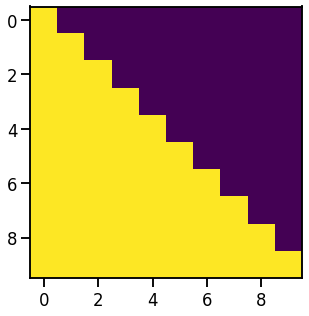

In [64]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(10)[0])

The yellow pixels represent unmasked positions, while the violet pixels represent masked positions. 

# ATTENTION

# ![](https://media.licdn.com/dms/image/sync/D5627AQH2lpiDbp45BA/articleshare-shrink_800/0/1684130793287?e=1684915200&v=beta&t=1U_5umrEcpITszj5N_IA5Cyx5VUdQZW_bBGOsCQMtdM)

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call our particular attention “Scaled Dot-Product Attention”. The input consists of queries and keys of dimension dk
, and values of dimension dv. We compute the dot products of the query with all keys, divide each by √dk, and apply a softmax function to obtain the weights on the values.

# ![](https://jamesmccaffrey.files.wordpress.com/2020/09/sdpa_picture_and_equation.jpg?w=584&h=246)

In [72]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

# MULTI-HEAD ATTENTION

# ![](https://qph.cf2.quoracdn.net/main-qimg-d83b04a913299ccb0411f4b3be2b73d1-lq)

In [75]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]        
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

The class here is `MultiHeadedAttention`, which implements the multi-headed attention mechanism in a transformer model. The multi-headed attention allows the model to focus on different parts of the input sequence simultaneously.

Here's an explanation of the class and its methods:

- `__init__(self, h, d_model, dropout=0.1)`: This is the initialization method of the `MultiHeadedAttention` class. It takes three arguments:
  - `h`: The number of attention heads.
  - `d_model`: The dimensionality of the input and output vectors.
  - `dropout`: The dropout probability.

Within this method:
- `assert d_model % h == 0` ensures that the input dimension is divisible by the number of attention heads. This is a requirement for evenly splitting the input into multiple heads.
- `self.d_k = d_model // h` calculates the dimensionality of each head by dividing `d_model` by the number of attention heads.
- `self.h = h` stores the number of attention heads.
- `self.linears` creates four linear transformation layers using the `clones` function. These layers will be used for linear projections in the attention mechanism.
- `self.attn` stores the attention weights.
- `self.dropout` is a dropout layer used for regularization.

- `forward(self, query, key, value, mask=None)`: This method implements the forward pass of the `MultiHeadedAttention` module. It takes four arguments:
  - `query`: The query tensor.
  - `key`: The key tensor.
  - `value`: The value tensor.
  - `mask`: An optional mask tensor to apply to the attention scores.

The forward pass follows the steps shown in Figure 2 of the original transformer paper. Here's a breakdown of the steps:
- If a `mask` is provided, it is unsqueezed to have an additional dimension representing the head.
- `nbatches = query.size(0)` calculates the number of batches based on the size of the query tensor.
- `query, key, value` are linearly projected using the corresponding linear transformation layers. The input tensors are first passed through the linear layers, and then reshaped and transposed to split the dimensions into the number of heads (`h`) and the projected dimension (`d_k`).
- `x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)` applies the attention mechanism to the projected queries, keys, and values. The `attention` function performs the attention operation and returns the output and attention weights.
- The output `x` is transposed, reshaped, and concatenated to obtain the final output tensor.
- The final output tensor is passed through the last linear transformation layer.

In summary, the `MultiHeadedAttention` class implements the multi-headed attention mechanism in a transformer model. During the forward pass, the input tensors are linearly projected into multiple heads, attention is applied to the projected tensors, and the outputs are concatenated and transformed again using a linear layer. This class enables the model to attend to different parts of the input sequence simultaneously and capture different types of information.

# POSITION-WISE FEED FORWARD NETWORK

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

In [79]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# EMBEDDINGS AND SOFTMAX

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension dmodel. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. 

In [84]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

# POSITIONAL ENCODING

The PositionalEncoding module computes the positional encoding values based on the position and dimensionality of the input sequence. During the forward pass, it adds the positional encoding to the input tensor and applies dropout to the output. The positional encoding provides positional information to the transformer model, allowing it to differentiate between elements in the input sequence based on their position.

In [87]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

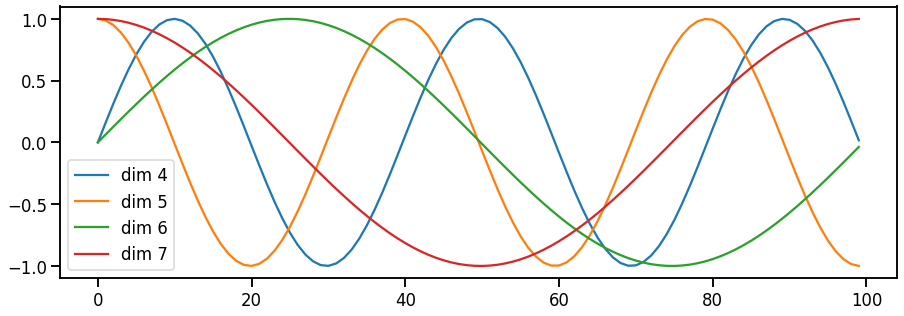

In [89]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])


# THE MODEL

In [95]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

tmp_model = make_model(10, 10, 2)
None

/tmp/ipykernel_18445/2894909393.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


# BATCHES AND MASKS

In [96]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

# TRAINING LOOP

In [124]:
def run_epoch(data_iter, model, loss_compute):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [100]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

# OPTIMIZER

In [102]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))



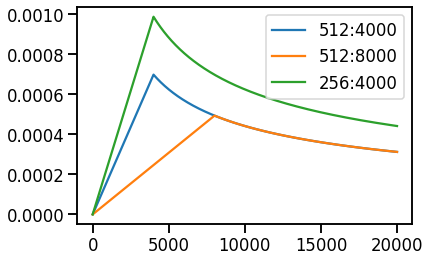

In [103]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

# REGULARIZATION

We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has confidence of the correct word and the rest of the smoothing mass distributed throughout the vocabulary.

In [106]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

 Here we can see an example of how the mass is distributed to the words based on confidence.

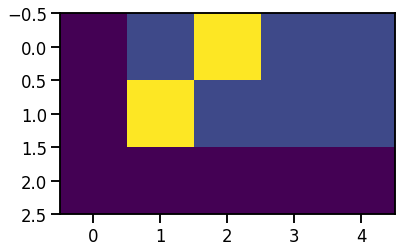

In [108]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))
plt.imshow(crit.true_dist)
None

In [113]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [116]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm

In [117]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

/tmp/ipykernel_18445/2894909393.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


Epoch Step: 1 Loss: 3.345043 Tokens per Sec: 1143.557495
Epoch Step: 1 Loss: 2.073213 Tokens per Sec: 1875.524048
tensor(1.9777)
Epoch Step: 1 Loss: 2.107600 Tokens per Sec: 1361.209961
Epoch Step: 1 Loss: 1.861382 Tokens per Sec: 1584.136719
tensor(1.8658)
Epoch Step: 1 Loss: 1.863299 Tokens per Sec: 965.319824
Epoch Step: 1 Loss: 1.568191 Tokens per Sec: 2009.837524
tensor(1.5873)
Epoch Step: 1 Loss: 1.739413 Tokens per Sec: 1126.593140
Epoch Step: 1 Loss: 1.345070 Tokens per Sec: 1519.589722
tensor(1.3395)
Epoch Step: 1 Loss: 1.343953 Tokens per Sec: 1066.461426
Epoch Step: 1 Loss: 0.871328 Tokens per Sec: 1651.389893
tensor(0.9274)
Epoch Step: 1 Loss: 1.216411 Tokens per Sec: 1228.501465
Epoch Step: 1 Loss: 0.660773 Tokens per Sec: 2023.590698
tensor(0.6599)
Epoch Step: 1 Loss: 0.730797 Tokens per Sec: 1378.561523
Epoch Step: 1 Loss: 0.495685 Tokens per Sec: 2211.919922
tensor(0.5819)
Epoch Step: 1 Loss: 1.014289 Tokens per Sec: 1227.059082
Epoch Step: 1 Loss: 0.496370 Tokens per S

In [123]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]))
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  9,  9, 10]])
